In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, InputLayer, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

Using TensorFlow backend.
E:\Users\lo485\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\Users\lo485\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\Users\lo485\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\Users\lo485\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
df = pd.read_csv("SPAM text message 20170820 - Data.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# explore data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
df.groupby('Category').describe().T

Category                           ham  \
Message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

Category                                                     spam  
Message count                                                 747  
        unique                                                641  
        top     Please call our customer service representativ...  
        freq                                                    4

Text(0.5, 1.0, 'Number of ham and spam messages')

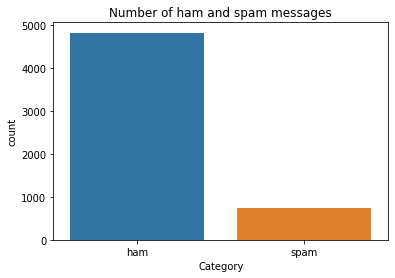

In [5]:
sns.countplot(df.Category)
plt.title("Number of ham and spam messages")

In [8]:
df['label'] = df['Category'].map({'spam': 1, 'ham': 0})
df

,Category,Message,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1
5568,ham,Will ü b going to esplanade fr home?,0
5569,ham,"Pity, * was in mood for that. So...any other s...",0
5570,ham,The guy did some bitching but I acted like i'd...,0


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(df['Message'], 
                                                    df['label'], test_size=0.2)

In [10]:
# preprocessing: make tokens out of text
vocab_size = 500
oov_tok = '<OOV>'
max_len = 50
token = Tokenizer(num_words=vocab_size, oov_token=oov_tok) # keep 500 words based on freq
token.fit_on_texts(X_train)

In [11]:
word_index = token.word_index
word_index

{'<OOV>': 1,
 'i': 2,
 'to': 3,
 'you': 4,
 'a': 5,
 'the': 6,
 'u': 7,
 'and': 8,
 'is': 9,
 'in': 10,
 'me': 11,
 'my': 12,
 'for': 13,
 'your': 14,
 'it': 15,
 'of': 16,
 'have': 17,
 'call': 18,
 'on': 19,
 'that': 20,
 '2': 21,
 'are': 22,
 'now': 23,
 'so': 24,
 'but': 25,
 'not': 26,
 'do': 27,
 'or': 28,
 'at': 29,
 'can': 30,
 "i'm": 31,
 'if': 32,
 'will': 33,
 'ur': 34,
 'get': 35,
 'with': 36,
 'no': 37,
 'be': 38,
 'just': 39,
 'we': 40,
 'this': 41,
 '4': 42,
 'up': 43,
 'when': 44,
 'free': 45,
 'go': 46,
 'gt': 47,
 'lt': 48,
 'all': 49,
 'ok': 50,
 'how': 51,
 'from': 52,
 'know': 53,
 'what': 54,
 'out': 55,
 'good': 56,
 'got': 57,
 'like': 58,
 'then': 59,
 'day': 60,
 'come': 61,
 'its': 62,
 'am': 63,
 'only': 64,
 'time': 65,
 'was': 66,
 'love': 67,
 'send': 68,
 'want': 69,
 'there': 70,
 'he': 71,
 'as': 72,
 'txt': 73,
 'text': 74,
 'one': 75,
 'going': 76,
 'about': 77,
 'by': 78,
 'need': 79,
 'home': 80,
 'ü': 81,
 'see': 82,
 'still': 83,
 'back': 84,
 "i

In [12]:
# Add padding to ensure all data are in the same shape
padding_type = 'post'
truncate_type = 'post'
train_sequences = token.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(train_sequences, maxlen=max_len, 
                                          padding=padding_type, truncating=truncate_type)

In [13]:
# RNN Model
model = Sequential()
model.add(InputLayer(input_shape=(max_len,), name='inputs'))
model.add(Embedding(vocab_size, 16, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            8000      
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 37,185
Trainable params: 37,185
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
history = model.fit(sequences_matrix, Y_train, batch_size=64, epochs=30, 
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

Train on 3565 samples, validate on 892 samples
Epoch 1/15
3565/3565 [==============================] - 2s 457us/step - loss: 0.0349 - accuracy: 0.9907 - val_loss: 0.1924 - val_accuracy: 0.9843
Epoch 2/15
3565/3565 [==============================] - 2s 457us/step - loss: 0.0337 - accuracy: 0.9910 - val_loss: 0.1434 - val_accuracy: 0.9854
Epoch 3/15
3565/3565 [==============================] - 2s 455us/step - loss: 0.0294 - accuracy: 0.9913 - val_loss: 0.1567 - val_accuracy: 0.9865
Epoch 4/15
3565/3565 [==============================] - 2s 463us/step - loss: 0.0283 - accuracy: 0.9924 - val_loss: 0.1381 - val_accuracy: 0.9821
Epoch 5/15
3565/3565 [==============================] - 2s 461us/step - loss: 0.0274 - accuracy: 0.9930 - val_loss: 0.1672 - val_accuracy: 0.9865
Epoch 6/15
3565/3565 [==============================] - 2s 463us/step - loss: 0.0297 - accuracy: 0.9879 - val_loss: 0.2335 - val_accuracy: 0.9787


Text(0.5, 0, 'epoch')

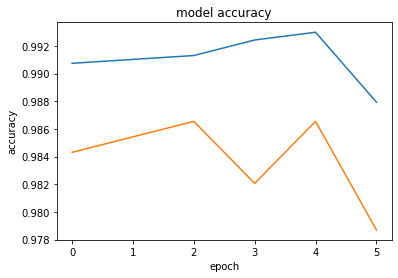

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [22]:
test_sequences = token.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [23]:
accr = model.evaluate(test_sequences_matrix,Y_test)

1115/1115 [==============================] - 0s 134us/step


In [24]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.200
  Accuracy: 0.969
